In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import igraph as ig
import os
import yaml
from os.path import join
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import entropy
from scipy import stats
from functools import reduce
import sys
sys.path.insert(1, '../..')
from utils import *
from collections import Counter
import geopandas as gpd
import matplotlib.ticker as ticker
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [26]:
FIG_SAVE_DIR = join('.', 'figures')
RESULT_SAVE_DIR = join('.', 'results')

matplotlib_style = 'seaborn-whitegrid'

In [27]:
with open(join('..', '..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']

AREA_NAME = 'NYC'
NETWORK_DIR = join(pwd, dpath, 'Nets', f'{AREA_NAME}-CBG-CBG-Nets')
nets = [(datetime.strptime(f, '%Y-%m-%d'), ig.Graph.Read_Pickle(join(NETWORK_DIR, f))) 
            for f in tqdm(os.listdir(NETWORK_DIR))]
nets = np.array(sorted(nets, key=lambda x: x[0]))

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:37<00:00,  2.86it/s]


In [36]:
def get_census_attrs(rank_list=[]):
    '''
    reads and prepares the census attributes
    `rank_list` stores the attributes to be worked as ranked values
    '''
    census_attrs = pd.read_csv(join(pwd, 'util_datasets', 'census_attributes.csv'))
    census_attrs = census_attrs[census_attrs['census_block_group'].isin(area_cbgs)]

    commuting_cols = [i for i in census_attrs.columns if i.startswith('t-')]
    census_attrs['mean_time_to_work'] = census_attrs.apply(mean_time_to_work, cols=commuting_cols, axis=1)

    edu_cols = [i for i in census_attrs.columns if 'edu-' in i]
    census_attrs['education'] = sum([census_attrs[i] for i in edu_cols])

    census_attrs['racial_diversity'] = census_attrs.apply(lambda row: entropy([row['white_population'], row['black_population'], row['asian_population'], row['hispanic_population']]), axis=1)
    census_attrs = census_attrs.rename(columns={'median_house_income': 'income'})

    col_names = ['income', 'white_population', 'black_population', 'asian_population', 'racial_diversity', 'hispanic_population', 'education', 'mean_time_to_work']
    quart = ['Bottom', 'Third', 'Second', 'Top']
    for col in col_names:
        census_attrs[f'{col}-quartile'] = pd.qcut(census_attrs[col], q=4, labels=[f'{quart[i]}' for i in range(4)])

    census_quartiles = census_attrs[['census_block_group', *[f'{cn}-quartile' for cn in col_names]]]
    census_raw_values = census_attrs[['census_block_group', *col_names]]
    
    for attr in rank_list:
        census_raw_values[attr] = census_raw_values[attr].rank(pct=True)
    
    return census_quartiles, census_raw_values

In [30]:
news_df = pd.read_csv(join('.', 'news-data', 'news.csv'))
news_df['timeStamp'] = pd.to_datetime(news_df['timeStamp'])
news_df.head(3)

,News Source,News Title,timeStamp,subject,glocations,organizations,persons
0,New York Times,The W.H.O. declared a global health emergency.,2020-01-30,NaN,NaN,WHO,NaN
1,New York Times,The United States reported a death.,2020-02-29,Deaths (Fatalities);,United States,NaN,NaN
2,New York Times,The C.D.C. recommended no gatherings of 50 or ...,2020-03-15,Guidelines,New York City,Centers for Disease Control and Prevention,NaN


In [33]:
news_df['subject'].unique()

array([nan, 'Deaths (Fatalities);', 'Guidelines',
       'Shutdowns (Institutional);Quarantines', 'Travel Restrictions;',
       'Hospitals;Ventilators (Medical)',
       'Coronavirus (2019-nCoV) Cases;', 'Doctors;',
       'Deaths (Fatalities);Morgues and Mortuaries',
       'Vaccination and Immunization', 'Quarantines;Travel and Vacations',
       'Coronavirus Reopenings;',
       'Coronavirus (2019-nCoV) Cases;Colleges and Universities',
       'Coronavirus (2019-nCoV) Cases; Disease Rates',
       'Coronavirus Reopenings; Education (K-12)',
       'White House Coronavirus Outbreak (2020)', 'Quarantines',
       'Morgues and Mortuaries', 'Quarantines ',
       'Vaccination and Immunization; Rumors and Misinformation',
       'Coronavirus (2019-nCoV) Cases;Deaths (Fatalities)', 'Mutations'],
      dtype=object)

In [31]:
def plot_mobility_news(networks, selected_news, deg_mode='in', title='', figname=None):
    '''
    plots the temporal change in mobility (wrt. deg_mode) and displays the selected news on the figure
    '''
    mob = np.array([sum(net[1].degree(mode=deg_mode)) for net in networks])
    mondays = np.array([net[0] for net in networks])
    
    with plt.style.context(matplotlib_style):
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))

        ax.plot(mondays, mob, marker='o', markersize=3)

        for date, title in selected_news:
            ax.axvline(date, linestyle='--')

        if figname:
            fig.savefig(join(FIG_SAVE_DIR, figname), dpi=300, bbox_inches='tight')

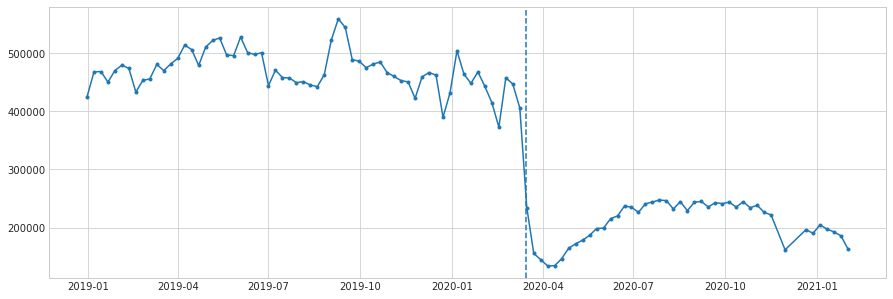

In [37]:
plot_mobility_news(nets, news_df[news_df['subject'] == 'Guidelines'][['timeStamp', 'News Title']].values[:])

In [8]:
census_attrs = pd.read_csv(join(pwd, 'util_datasets', 'news_attrs.csv'))
census_attrs = census_attrs.rename(columns={'agg_household_income': 'income'})
census_attrs.head()

,census_block_group,median_house_income,income,per_capita_income,median_age,B01001e1,white_population,B01001e1.1,black_population,B01001e1.2,...,edu-phd,t-60-80,t-0-10,t-10-14,t-15-19,t-20-24,t-25-29,t-30-24,t-35-44,t-45-59
0,10010201001,NaN,14126600.0,20365.0,34.1,745,585,745,160,745,...,16,11,93,50,26,0,0,66,28,23
1,10010201002,77813.0,41514300.0,33336.0,41.8,1265,1083,1265,104,1265,...,9,14,39,81,37,66,23,249,91,57
2,10010202001,25179.0,15608200.0,17047.0,38.2,960,361,960,568,960,...,0,11,17,21,92,36,74,63,12,15
3,10010202002,45104.0,25847500.0,21400.0,39.7,1236,615,1236,571,1236,...,6,19,86,71,95,17,32,114,63,32
4,10010203001,55222.0,50827900.0,23106.0,34.9,2364,1481,2364,515,2364,...,18,30,115,169,69,206,89,268,0,143


In [10]:
census_attrs['cbg-str'] = census_attrs.census_block_group.astype(str)
census_attrs['county'] = census_attrs['cbg-str'].apply(lambda x: x[:5] if len(x) == 12 else x[:4])
income = census_attrs.groupby('county').mean()['income'].reset_index()

In [16]:
edu_cols = [i for i in census_attrs.columns if 'edu-' in i]
edu = census_attrs.groupby('county').sum()[['B15003e1', *edu_cols]].reset_index()
edu['education'] = edu[edu_cols].sum(axis=1) / edu['B15003e1']

In [23]:
pd.concat([income,edu.drop('county', axis=1)],axis=1)[['county', 'income', 'education']].to_csv('county_census.csv', index=False)